## Get env

In [1]:
!nvidia-smi

Sat Aug 14 22:06:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.11       Driver Version: 471.11       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
| 30%   56C    P5   104W / 370W |   1281MiB / 24576MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# 環境によって処理を変えるためのもの
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = 'kaggle_web_client' in sys.modules
LOCAL = not (IN_KAGGLE or IN_COLAB)
print(f'IN_COLAB:{IN_COLAB}, IN_KAGGLE:{IN_KAGGLE}, LOCAL:{LOCAL}')

IN_COLAB:False, IN_KAGGLE:False, LOCAL:True


In [3]:
# For Colab Download some datasets
# ==================
if IN_COLAB:
    # mount googledrive
    from google.colab import drive
    drive.mount('/content/drive')
    # copy kaggle.json from googledrive
    ! pip install --upgrade --force-reinstall --no-deps  kaggle > /dev/null
    ! mkdir ~/.kaggle
    ! cp "/content/drive/MyDrive/kaggle/kaggle.json" ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    
    # if not os.path.exists("/content/input/train_short_audio"):
    #     !mkdir input
    #     !kaggle competitions download -c birdclef-2021
    #     !unzip /content/birdclef-2021.zip -d input

In [4]:
if IN_KAGGLE:
    !pip install --upgrade -q wandb
    !pip install -q pytorch-lightning
    !pip install torch_optimizer

## Import Libraries

In [5]:
if IN_KAGGLE:
    sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

# Hide Warning
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Python Libraries
import os
import math
import random
import glob
from collections import defaultdict
from pathlib import Path

# Third party
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualizations
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.express as px
%matplotlib inline
sns.set(style="whitegrid")

# Utilities and Metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim.optimizer import Optimizer, required
import torch_optimizer as optim

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Callback, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger, CSVLogger

# Pytorch Image Models
import timm

# Image Augmentation Library
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as AF

# Weights and Biases Tool
import wandb
os.environ["WANDB_API_KEY"]='68fa1bbcda0fcf7a56f3c33a0fafa45b02f1c52d'
wandb.login()

wandb: Currently logged in as: teyosan1229 (use `wandb login --relogin` to force relogin)


True

## Config

In [6]:
class CFG:
    debug = True
    exp_name = "ex005_local"
    seed = 29
    # model
    model_name = 'efficientnet_b0'
    pretrained = True
    img_size = 224
    in_chans = 1
    target_col = 'target' # 目標値のある列名
    target_size = 1
    # optimizer
    optimizer_name = 'RAdam'
    lr = 1e-3
    weight_decay = 1e-5
    amsgrad = False
    # scheduler
    epochs = 10
    scheduler = 'CosineAnnealingLR'
    T_max = 10
    min_lr = 1e-5
    # criterion
    criterion_name = 'BCEWithLogitsLoss'
    
    # training
    train = True
    inference = False
    n_fold = 5
    trn_fold = [0]
    precision = 16 #[16, 32, 64]
    grad_acc = 1
    # DataLoader
    loader = {
        "train": {
            "batch_size": 128,
            "num_workers": 0,
            "shuffle": True,
            "pin_memory": True,
            "drop_last": True
        },
        "valid": {
            "batch_size": 128,
            "num_workers": 0,
            "shuffle": False,
            "pin_memory": True,
            "drop_last": False
        }
    }

## Directory & LoadData

In [7]:
if IN_KAGGLE:
    INPUT_DIR = Path('../input/seti-breakthrough-listen')
    OUTPUT_DIR = './'
elif IN_COLAB:
    INPUT_DIR = Path('/content/input/')
    OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/BirdClef2021/{CFG.exp_name}/'
if LOCAL:
    INPUT_DIR = Path("F:/Kaggle/seti-breakthrough-listen/data/input/")
    OUTPUT_DIR = f'F:/Kaggle/seti-breakthrough-listen/data/output/{CFG.exp_name}/'

TRAIN_DIR = INPUT_DIR / "train"
TEST_DIR = INPUT_DIR / "test"

df_train = pd.read_csv(INPUT_DIR / "train_labels.csv")
df_test = pd.read_csv(INPUT_DIR / "sample_submission.csv")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

if CFG.debug:
    CFG.epochs = 2
    df_train = df_train.sample(n=10000, random_state=CFG.seed).reset_index(drop=True)

In [8]:
def get_filepath(name, folder=TRAIN_DIR):
    path = os.path.join(folder, name[0], f'{name}.npy')
    return path

df_train['image_path'] = df_train['id'].apply(lambda x: get_filepath(x, TRAIN_DIR))
df_test['image_path'] = df_test['id'].apply(lambda x: get_filepath(x, TEST_DIR))
print(df_train.shape, df_test.shape)
df_train.head()

(10000, 3) (39995, 3)


,id,target,image_path
0,a861977733fcbf6,0,F:\Kaggle\seti-breakthrough-listen\data\input\...
1,34fffe5f3e3fedf,0,F:\Kaggle\seti-breakthrough-listen\data\input\...
2,a7a9a09832085b1,0,F:\Kaggle\seti-breakthrough-listen\data\input\...
3,de2ef85d23501a5,1,F:\Kaggle\seti-breakthrough-listen\data\input\...
4,2ce2212af03d789,0,F:\Kaggle\seti-breakthrough-listen\data\input\...


In [9]:
np.load(df_train.loc[0, 'image_path']).shape

(6, 273, 256)

## Utils

In [10]:
seed_everything(CFG.seed)
# LINEに通知
import requests
def send_line_notification(message):
    line_token = '8vBbxd0jENU39kV2ROEwp78jAzeankBFi7AG0JjoU3j'
    endpoint = 'https://notify-api.line.me/api/notify'
    message = f"{message}"
    payload = {'message': message}
    headers = {'Authorization': 'Bearer {}'.format(line_token)}
    requests.post(endpoint, data=payload, headers=headers)

Global seed set to 29


## CV Split

In [11]:
df_train["fold"] = -1
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(df_train, df_train[CFG.target_col])):
    df_train.loc[val_index, 'fold'] = int(n)
df_train['fold'] = df_train['fold'].astype(int)
print(df_train.groupby(['fold', CFG.target_col]).size())

fold  target
0     0         1809
      1          191
1     0         1809
      1          191
2     0         1808
      1          192
3     0         1808
      1          192
4     0         1808
      1          192
dtype: int64


### Grid maskは今は飛ばす

## Transforms

In [12]:
def get_transforms(phase: str):
    if phase == 'train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            #Normalize(
            #    mean=[0.485, 0.456, 0.406],
            #    std=[0.229, 0.224, 0.225],
            #),
            ToTensorV2(p=1.0),
        ])
    elif phase == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
            #Normalize(
            #    mean=[0.485, 0.456, 0.406],
            #    std=[0.229, 0.224, 0.225],
            #),
            ToTensorV2(p=1.0),
        ])


## Dataset

In [13]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_path'].values
        self.targets = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.image_paths[idx]
        # タスクに合わせたロード方法
        image = np.load(file_path).astype(np.float32)# (6, 273, 256)
        image = np.vstack(image).transpose((1, 0))# (1638, 256) -> (256, 1638)
        #image = cv2.imread(file_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)["image"]
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        label = torch.tensor(self.targets[idx]).float()
        return image, label

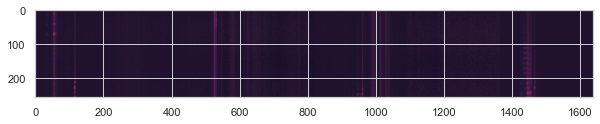

In [14]:
plt.figure(figsize=(10, 5))
image = np.load(df_train.loc[1, 'image_path']).astype(np.float32)
image = np.vstack(image).transpose((1, 0))
plt.imshow(image)

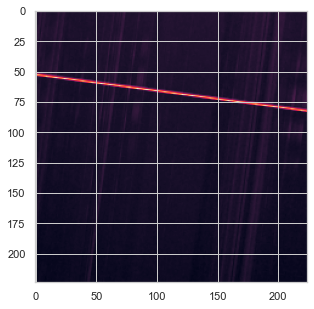

In [15]:
plt.figure(figsize=(5, 5))
train_dataset = TrainDataset(df_train, transform=get_transforms(phase='train'))
image, _ = train_dataset[0]
plt.imshow(image[0])

## DataModule

In [16]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, train_data, valid_data, test_data):
        super().__init__()
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        
    # 必ず呼び出される関数
    def setup(self, stage=None):
        self.train_dataset = TrainDataset(self.train_data, transform=get_transforms(phase='train'))
        self.valid_dataset = TrainDataset(self.valid_data, transform=get_transforms(phase='valid'))
        self.test_dataset = TrainDataset(self.test_data, transform=get_transforms(phase='valid'))
        
    # Trainer.fit() 時に呼び出される
    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=CFG.loader["train"]["batch_size"],
                          shuffle=True,
                          num_workers=CFG.loader["train"]["num_workers"],
                          pin_memory=True,
                          drop_last=True)

    # Trainer.fit() 時に呼び出される
    def val_dataloader(self):
        return DataLoader(self.valid_dataset,
                          batch_size=CFG.loader["valid"]["batch_size"],
                          shuffle=False,
                          num_workers=CFG.loader["valid"]["num_workers"],
                          pin_memory=True,
                          drop_last=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=CFG.loader["valid"]["batch_size"],
                          shuffle=False,
                          num_workers=CFG.loader["valid"]["num_workers"],
                          pin_memory=True,
                          drop_last=False)

## Pytorch Lightning Module

In [17]:
# ====================================================
# model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(model_name=self.cfg.model_name,
                                       pretrained=pretrained,
                                       in_chans=self.cfg.in_chans,
                                       num_classes=self.cfg.target_size)
        
    def forward(self, x):
        output = self.model(x)
        return output
    
def get_model(cfg):
    model = CustomModel(cfg, pretrained=cfg.pretrained)
    # plだと要らない？
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model.to(device)
    # model.eval()
    return model

# ====================================================
# criterion
# ====================================================
def get_criterion():
    if CFG.criterion_name == 'BCEWithLogitsLoss':
        # plだとto(device)いらない
        criterion = nn.BCEWithLogitsLoss(reduction="mean")
    if CFG.criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    else:
        raise NotImplementedError
    return criterion
# ====================================================
# optimizer
# ====================================================
def get_optimizer(model: nn.Module, config: dict):
    """
    input:
    model:model
    config:optimizer_nameやlrが入ったものを渡す
    
    output:optimizer
    """
    optimizer_name = config.optimizer_name
    if 'Adam' == optimizer_name:
        return Adam(model.parameters(),
                    lr=config.lr,
                    weight_decay=config.weight_decay,
                    amsgrad=config.amsgrad)
    elif 'RAdam' == optimizer_name:
        return optim.RAdam(model.parameters(),
                           lr=config.lr,
                           weight_decay=config.weight_decay)
    else:
        raise NotImplementedError

# ====================================================
# scheduler
# ====================================================
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        """
        factor : 学習率の減衰率
        patience : 何ステップ向上しなければ減衰するかの値
        eps : nanとかInf回避用の微小数
        """
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        """
        T_max : 1 半周期のステップサイズ
        eta_min : 最小学習率(極小値)
        """
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        """
        T_0 : 初期の繰りかえし回数
        T_mult : サイクルのスケール倍率
        """
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
    else:
        raise NotImplementedError
    return scheduler

[0.001, 0.0009757729755661011]


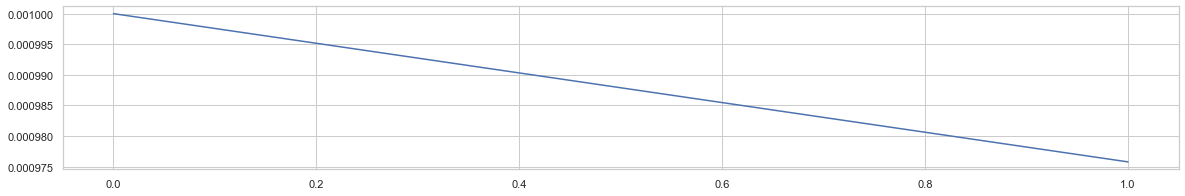

In [18]:
model=timm.create_model(model_name="resnet18",pretrained=False)
optimizer = get_optimizer(model, CFG)
scheduler = get_scheduler(optimizer)
from pylab import rcParams
lrs = []
for epoch in range(1, CFG.epochs+1):
    scheduler.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
print(lrs)
plt.plot(lrs)

In [19]:
optimizer.param_groups[0]["lr"]

0.0009757729755661011

In [20]:
class Trainer(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        print(cfg.model_name)
        self.model = get_model(cfg)
        self.criterion = get_criterion()
    
    def forward(self, x):
        output = self.model(x)
        return output
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        # mixup とかしたい場合はここに差し込む
        output = self.forward(x)
        labels = y.unsqueeze(1)
        loss = self.criterion(output, labels)
        try:
            auc=roc_auc_score(labels.detach().cpu(), output.sigmoid().detach().cpu()) 
            # Log loss and metric
            self.log("auc", auc, on_step= True, prog_bar=True, logger=True)
            self.log('train_loss', loss)
            
        except:
            pass
        
        return {"loss": loss, "predictions": output, "labels": labels}
    
    def training_epoch_end(self, outputs):
        preds = []
        labels = []
        
        for output in outputs:
            preds += output['predictions']
            labels += output['labels']

        labels = torch.stack(labels)
        preds = torch.stack(preds)

        train_auc=roc_auc_score(labels.detach().cpu(), preds.sigmoid().detach().cpu())
        self.log("mean_train_auc", train_auc, prog_bar=True, logger=True)
        self.log("lr", self.optimizer.param_groups[0]['lr'], prog_bar=True, logger=True)
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        labels = y.unsqueeze(1)
        loss = self.criterion(output, labels)
        self.log('val_loss', loss, on_step= True, prog_bar=True, logger=True)
        return {"predictions": output, "labels": labels}
    
    def validation_epoch_end(self, outputs):
        preds = []
        labels = []
        
        for output in outputs:
            preds += output['predictions']
            labels += output['labels']

        labels = torch.stack(labels)
        preds = torch.stack(preds)

        val_auc=roc_auc_score(labels.detach().cpu(), preds.sigmoid().detach().cpu())
        self.log("val_auc", val_auc, prog_bar=True, logger=True)
        
    def test_step(self, batch, batch_idx):
        x = batch        
        output = self(x).sigmoid()
        return output
    
    def configure_optimizers(self):
        ### optimizer
        #optimizer = get_optimizer(self.parameters(), self.cfg)
        self.optimizer = get_optimizer(self, self.cfg)
        self.scheduler = get_scheduler(self.optimizer)
        return {'optimizer': self.optimizer, 'lr_scheduler': self.scheduler}

## Train

In [21]:
def train() -> None:
    for fold in range(CFG.n_fold):
        if not fold in CFG.trn_fold:
            continue
        print(f"{'='*38} Fold: {fold} {'='*38}")
        # Logger
        #======================================================
        lr_monitor = LearningRateMonitor(logging_interval='step')
        # 学習済重みを保存するために必要
        loss_checkpoint = ModelCheckpoint(
            dirpath=OUTPUT_DIR,
            filename=f"best_loss_fold{fold}",
            monitor="val_loss",
            save_last=True,
            save_top_k=1,
            save_weights_only=True,
            mode="min",
        )
        auc_checkpoint = ModelCheckpoint(
            dirpath=OUTPUT_DIR,
            filename=f"best_auc_fold{fold}",
            monitor="val_auc",
            save_top_k=1,
            save_weights_only=True,
            mode="max",
        )
        
        wandb_logger = WandbLogger(
            project='SETI-Lightning',
            group= f'{CFG.exp_name}',
            name = f'Fold{fold}',
            save_dir=OUTPUT_DIR
        )
        
        data_module = DataModule(
          df_train[df_train['fold']!=fold],
          df_train[df_train['fold']==fold], 
          df_train[df_train['fold']==fold], 
        )
        data_module.setup()
        #early_stopping_callback = EarlyStopping(monitor='val_auc',mode="max", patience=2)
        
        trainer = pl.Trainer(
            logger=wandb_logger,
            callbacks=[loss_checkpoint, auc_checkpoint, lr_monitor],
            default_root_dir=OUTPUT_DIR,
            gpus=1,
            progress_bar_refresh_rate=1,
            accumulate_grad_batches=CFG.grad_acc,
            max_epochs=CFG.epochs,
            precision=CFG.precision,
            benchmark=False,
            deterministic=True,
        )
        model = Trainer(CFG)
        trainer.fit(model, data_module)
        wandb.finish()
        
        

In [22]:
train()
send_line_notification("[locl]finished")
wandb.finish()

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


====================================== Fold: 0 ======================================
efficientnet_b0


D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name      | Type              | Params
------------------------------------------------
0 | model     | CustomModel       | 4.0 M 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.033    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 29


Training: -1it [00:00, ?it/s]

D:\python\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:398: LightningDeprecationWarning: One of the returned values {'predictions', 'labels'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

lr-RAdam,0.00098
trainer/global_step,123
_step,39
_runtime,92
_timestamp,1628946499
auc,0.562
train_loss,0.99355
epoch,1
val_loss_step,0.49575
val_loss_epoch,0.80804
val_auc,0.49018


lr-RAdam,█▁
trainer/global_step,▄▄▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▇▇▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▅▅▇▇▇▇▇▇████████████
_timestamp,▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▅▅▇▇▇▇▇▇████████████
auc,▁█
train_loss,▁█
epoch,▁▁▁███
val_loss_step,▄█▄▄▆▃▇▄▇▃▆▄▅▅▄▃▂▅▂▂▂▁▆▃▅▃▃▃▄▃▃▁
val_loss_epoch,█▁
val_auc,▁█


In [23]:
OUTPUT_DIR

'F:/Kaggle/seti-breakthrough-listen/data/output/test/'